## Background

In a [previous blog post](https://vishalbakshi.github.io/blog/posts/2024-08-13-tinystories-33m-finetune/) I finetuned the TinyStories-33M model on the `financial_phrasebank` dataset and achieved a ~85% accuracy on the validation set and an ~80% accuracy on the test set.

In this notebook, I'll finetune the much smaller TinyStories-8M model and see how it performs. I expect it to perform worse. In future notebooks, I'll also finetune the 3M and 1M TinyStories models. I also suspect these models might perform better on a (synthetically generated) simpler version of this dataset, which I plan to explore in a future notebook.

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"

#!pip install accelerate evaluate datasets -Uqq
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
#model_nm = "roneneldan/TinyStories-33M"
#model_nm = "roneneldan/TinyStories-1M"
#model_nm = "roneneldan/TinyStories-3M"
model_nm = "roneneldan/TinyStories-8M"

tokz = AutoTokenizer.from_pretrained(model_nm)
def tok_func(x): return tokz(x["input"], padding=True, truncation=True)

## Preparing Datasets

Much of the code in this section is boilerplate, tokenizing the dataset and splitting it into training, validation and test sets.

In [ ]:
#| code-fold: true
#| code-summary: "Show load_dataset"

dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree",
    split="train"  # note that the dataset does not have a default test split
)

dataset = dataset.rename_columns({'label':'labels', 'sentence': 'input'})

In [ ]:
tokz.add_special_tokens({'pad_token': '[PAD]'})
tokz.padding_side = "left" # https://github.com/huggingface/transformers/issues/16595 and https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch
tok_ds = dataset.map(tok_func, batched=True)

In [4]:
tok_ds[0]['input']

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [5]:
tok_ds[0]['input_ids'][100:110] # first 100 elements are 50257 ('[PAD]')

[50257, 50257, 50257, 50257, 50257, 50257, 4821, 284, 17113, 837]

In [6]:
tokz.decode(50257), tokz.decode(4821), tokz.decode(284), tokz.decode(17113)

('[PAD]', 'According', ' to', ' Gran')

In [7]:
tok_ds[0]['labels']

1

In [8]:
split_dataset = tok_ds.train_test_split(test_size=225/2264, seed=42)

training_split = split_dataset['train'].train_test_split(test_size=0.2, seed=42)

train_ds = training_split['train']
eval_ds = training_split['test']
test_ds = split_dataset['test']

train_ds, eval_ds, test_ds

(Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 1631
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 408
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 225
 }))

In [9]:
train_ds[0]['input']

'The result will also be burdened by increased fixed costs associated with operations in China , and restructuring costs in Japan .'

In [10]:
train_ds[0]['labels']

0

The dataset distributions show a predominance of `neutral` (`1`) sentences:

In [11]:
train_ds.to_pandas()['labels'].value_counts() / len(train_ds)

labels
1    0.622318
2    0.251993
0    0.125690
Name: count, dtype: float64

In [12]:
eval_ds.to_pandas()['labels'].value_counts() / len(eval_ds)

labels
1    0.615196
2    0.257353
0    0.127451
Name: count, dtype: float64

In [13]:
test_ds.to_pandas()['labels'].value_counts() / len(test_ds)

labels
1    0.555556
2    0.240000
0    0.204444
Name: count, dtype: float64

## Prepare for Training

Much of the code in this section is either helper functions (like `get_acc`, `MetricCallback`, or `results_to_dataframe`) or boilerplate code to prepare a HuggingFace trainer:

In [16]:
def get_acc(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

In [17]:
#| code-fold: true
#| code-summary: "Show MetricCallback code"

# thanks Claude

class MetricCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []
        self.current_epoch_metrics = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.current_epoch_metrics.update(logs)

    def on_epoch_end(self, args, state, control, **kwargs):
        if hasattr(state, 'log_history') and state.log_history:
            # Get the last logged learning rate
            last_lr = state.log_history[-1].get('learning_rate', None)
        else:
            last_lr = None

        self.metrics.append({
            "epoch": state.epoch,
            "learning_rate": last_lr,
            **self.current_epoch_metrics
        })
        self.current_epoch_metrics = {}  # Reset for next epoch

    def on_train_end(self, args, state, control, **kwargs):
        # Capture final metrics after the last epoch
        if self.current_epoch_metrics:
            self.metrics.append({
                "epoch": state.num_train_epochs,
                "learning_rate": self.metrics[-1].get('learning_rate') if self.metrics else None,
                **self.current_epoch_metrics
            })

In [18]:
#| code-fold: true
#| code-summary: "Show function to convert results dict into DataFrame"

def results_to_dataframe(results, model_name):
    rows = []
    for result in results:
        initial_lr = result['learning_rate']
        for metric in result['metrics']:
            row = {
                'model_name': model_name,
                'initial_learning_rate': initial_lr,
                'current_learning_rate': metric.get('learning_rate'),
            }
            row.update(metric)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Ensure specific columns are at the beginning
    first_columns = ['model_name', 'initial_learning_rate', 'current_learning_rate', 'epoch']
    other_columns = [col for col in df.columns if col not in first_columns]
    df = df[first_columns + other_columns]
    
    return df

In [19]:
#| code-fold: true
#| code-summary: "Show function to make confusion matrix"

def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['pred_text'], labels=['negative', 'neutral', 'positive'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])
    
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax,text_kw={'fontsize': 12}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

In [20]:
#| code-fold: true
#| code-summary: "Show function to generate a prediction"

def get_prediction(model, text, tokz):
    # Determine the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the appropriate device
    model = model.to(device)

    # Tokenize the input text
    inputs = tokz(text, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model's prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Ensure logits are on CPU for numpy operations
    logits = outputs.logits.detach().cpu()

    # Get probabilities
    probs = torch.softmax(logits, dim=-1)

    # Get the predicted class
    p_class = torch.argmax(probs, dim=-1).item()

    # Get the probability for the predicted class
    p = probs[0][p_class].item()

    labels = {0: "negative", 1: "neutral", 2: "positive"}
    
    print(f"Probability: {p:.2f}")
    print(f"Predicted label: {labels[p_class]}")
    return p_class, p

In [21]:
#| code-fold: true
#| code-summary: "Show function to prep trainer"

def get_trainer(lr, bs=16):

    args = TrainingArguments(
        'outputs',
        learning_rate=lr,
        warmup_ratio=0.1,
        lr_scheduler_type='cosine',
        fp16=True,
        eval_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs*2,
        num_train_epochs=3,
        weight_decay=0.01,
        report_to='none')
    
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3) # 3 labels for 3 classes
    model.resize_token_embeddings(len(tokz))
    model.config.pad_token_id = model.config.eos_token_id
    
    trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=eval_ds, 
                  tokenizer=tokz, compute_metrics=get_acc, callbacks=[metric_callback])
    
    return trainer, args

In [22]:
#| code-fold: true
#| code-summary: "Show function to get test set accuracy"

def get_test_df(trainer):
    test_df = test_ds.to_pandas()[['input', 'labels']]
    
    preds = trainer.predict(test_ds).predictions.astype(float)
    probs = F.softmax(torch.tensor(preds), dim=1)
    predicted_classes = torch.argmax(probs, dim=1).numpy()

    test_df['predicted'] = predicted_classes
    
    test_df['match'] = test_df['labels'] == test_df['predicted']
    acc = test_df['match'].mean()
    
    label_map = {i: label_text for i, label_text in enumerate(test_ds.features["labels"].names)}
    test_df['label_text'] = test_df['labels'].apply(lambda x: label_map[x])
    test_df['pred_text'] = test_df['predicted'].apply(lambda x: label_map[x])
    
    return test_df, acc

## Training: Learning Rate Sweep

While there are other hyperparameters to tune (`warmup_ratio`, `weight_decay`) I'll focus this notebook on fine-tuning with different learning rates. I'll start with the same learning rates that I used for the 33M model:

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"

metrics = []
trainers = []
learning_rates = [1e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 1e-2, 1e-1]

for lr in learning_rates:
    print(f"Learning Rate: {lr}")
    
    metric_callback = MetricCallback()
    
    trainer, args = get_trainer(lr, bs=64)

    trainer.train()

    metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    trainers.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [25]:
metrics_df = results_to_dataframe(metrics, model_name="TinyStories-8M")
metrics_df = metrics_df.query('current_learning_rate.notna()')

## Results

### Highest Validation Set Accuracy

The highest validation set accuracy (82%) was obtained with a learning rate of 8e-5.

In [26]:
metrics_df.query('eval_accuracy == eval_accuracy.max()')

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
19,TinyStories-8M,0.00008,0.0,3.0,0.0,0.2323,632259.5,0.44796,0.823529,0.4288,951.429,4.664,12.5028,391.353,3.119,2.427998e+13,0.49546


In [28]:
learning_rates[4]

8e-05

This model actually has a higher test accuracy than the 33M model (81% > 79%)---a result that I was not expecting!

In [29]:
test_df, acc = get_test_df(trainers[4])
acc

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.8133333333333334

This 8M parameter finetuned model predicts `neutral` sentences the best (117/125) followed by `positive` sentences (39/54) and lastly, `negative` sentences (27/46). It's interesting to note that the dataset contains a majority of `neutral` sentences, followed by `positive` sentences and the least represented sentiment is `negative`.

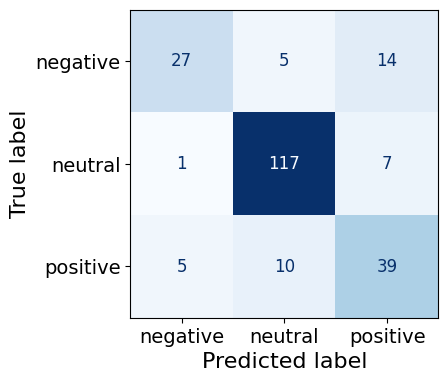

In [30]:
make_cm(test_df)

As the learning rate increases (starting at 1e-6) the validation set accuracy increases until it reaches a peak at a learning rate of 8e-5.

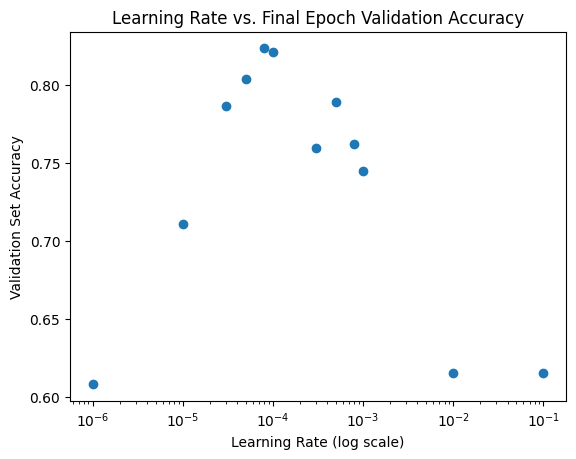

In [31]:
#| code-fold: true
#| code-summary: "Show plotting code"
final_epoch_metrics = metrics_df.query("epoch == 3")
plt.scatter(final_epoch_metrics['initial_learning_rate'], final_epoch_metrics['eval_accuracy']);
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Set Accuracy')
plt.title('Learning Rate vs. Final Epoch Validation Accuracy');

I'll test the model (run a "sanity check") on three made-up sentences. I don't want to weigh these results too much as they are cherry-picked sentences, but this model only gets one of them right and predicts all three as `negative`.

In [37]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(trainers[4].model, text, tokz)

Probability: 0.72
Predicted label: negative


In [38]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(trainers[4].model, text, tokz)

Probability: 0.62
Predicted label: negative


In [39]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(trainers[4].model, text, tokz)

Probability: 0.68
Predicted label: negative


### Highest Test Set Accuracy

In [ ]:
#| code-fold: true
#| code-summary: "Show accuracy calculation loop"
test_dfs = []
accs = []
for t in trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

The learning rate with the highest test set accuracy (83%) is 5e-4. Interestingly, this was the same learning rate for the 33M model.

In [41]:
accs

[0.5733333333333334,
 0.6844444444444444,
 0.7333333333333333,
 0.7822222222222223,
 0.8133333333333334,
 0.8177777777777778,
 0.7333333333333333,
 0.8266666666666667,
 0.6755555555555556,
 0.6888888888888889,
 0.5555555555555556,
 0.5555555555555556]

In [42]:
learning_rates[7]

0.0005

This learning rate had a validation set accuracy of about 79%.

In [43]:
final_epoch_metrics.query("initial_learning_rate == 0.0005")

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
31,TinyStories-8M,0.0005,0.0,3.0,0.0,0.3891,264843.125,0.543861,0.789216,0.4398,927.714,4.548,12.8595,380.498,3.033,2.427998e+13,0.846817


This model gets 121/125 `neutral` predictions correct, followed by 40/54 `positive` predictions and 25/46 `negative` predictions.

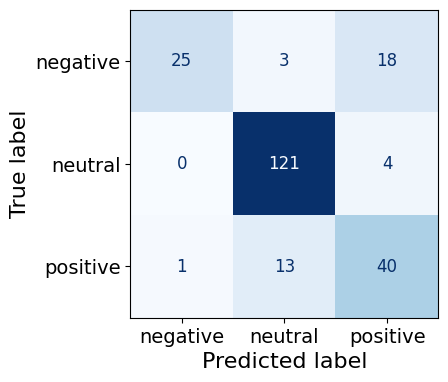

In [44]:
make_cm(test_dfs[7])

Interestingly, it also gets 1/3 of my "sanity check" predictions correct, predicting all three as `positive`.

In [45]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.65
Predicted label: positive


In [46]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.64
Predicted label: positive


In [47]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.63
Predicted label: positive


## Training with the Best Learning Rates 10 Times

Since I have different models achieving the highest validation set accuracy and the highest test set accuracy, I'll train 10 models for each learning rate to see if the results are consistent.

### LR = 8e-5 (Highest Validation Set Accuracy)

In [51]:
learning_rates[4]

8e-05

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"
best_metrics = []
best_trainers = []
lr = learning_rates[4]

for i in range(10):
    
    metric_callback = MetricCallback()
    trainer, args = get_trainer(lr=lr, bs=64)
    trainer.train()

    best_metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    best_trainers.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [53]:
best_metrics_df = results_to_dataframe(best_metrics, model_name="TinyStories-8M")
best_metrics_df = best_metrics_df.query('current_learning_rate.notna()')
best_metrics_df.head(3)

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,TinyStories-8M,0.00008,0.000068,1.0,0.000068,0.9671,313453.1875,0.689426,0.725490,0.4443,918.268,4.501,NaN,NaN,NaN,NaN,NaN
2,TinyStories-8M,0.00008,0.000024,2.0,0.000024,0.4975,948153.7500,0.490408,0.799020,0.4386,930.177,4.560,NaN,NaN,NaN,NaN,NaN
3,TinyStories-8M,0.00008,0.000000,3.0,0.000000,0.2880,589967.1875,0.427528,0.848039,0.4433,920.448,4.512,12.7188,384.706,3.066,2.427998e+13,0.584194


Similar to the 33M model, 9 out of the 10 training runs resulted in the exact same final validation set accuracy. I'm not sure why this behavior persists---I'll have to look at my `Trainer` setup and see if there's something awry?

In [54]:
final_accs = best_metrics_df.query("epoch == 3")['eval_accuracy']
final_accs.describe()

count    10.000000
mean      0.825980
std       0.007751
min       0.823529
25%       0.823529
50%       0.823529
75%       0.823529
max       0.848039
Name: eval_accuracy, dtype: float64

In [55]:
final_accs.value_counts()

eval_accuracy
0.823529    9
0.848039    1
Name: count, dtype: int64

In [ ]:
#| code-fold: true
#| code-summary: "Show accuracy calculation loop"
test_dfs = []
accs = []
for t in best_trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

Similarly, 9 out of the 10 training runs resulted in the same test set accuracy. One of the models resulted in an 86% test set accuracy! This is higher than the 33M model's best validation set accuracy.

In [58]:
accs = pd.Series(accs)
accs.value_counts()

0.813333    9
0.862222    1
Name: count, dtype: int64

For what it's worth (not much) the best model (85% validation set and 86% test set accuracy) gets 2/3 of my sanity check sentences right.

In [60]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(best_trainers[0].model, text, tokz)

Probability: 0.72
Predicted label: positive


In [61]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(best_trainers[0].model, text, tokz)

Probability: 0.53
Predicted label: negative


In [62]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(best_trainers[0].model, text, tokz)

Probability: 0.59
Predicted label: positive


### LR = 5e-4 (Highest Test Set Accuracy)

In [66]:
learning_rates[7] == 5e-4

True

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"
best_metrics2 = []
best_trainers2 = []
lr = learning_rates[7]

for i in range(10):
    
    metric_callback = MetricCallback()
    trainer, args = get_trainer(lr=lr, bs=64)
    trainer.train()

    best_metrics2.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    best_trainers2.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [69]:
best_metrics_df2 = results_to_dataframe(best_metrics2, model_name="TinyStories-8M")
best_metrics_df2 = best_metrics_df2.query('current_learning_rate.notna()')
best_metrics_df2.head(3)

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,TinyStories-8M,0.0005,0.000423,1.0,0.000423,1.6448,869443.6875,0.980524,0.502451,0.4321,944.212,4.628,NaN,NaN,NaN,NaN,NaN
2,TinyStories-8M,0.0005,0.000152,2.0,0.000152,0.7600,829335.1250,0.678928,0.725490,0.4317,945.012,4.632,NaN,NaN,NaN,NaN,NaN
3,TinyStories-8M,0.0005,0.000000,3.0,0.000000,0.5742,317736.5625,0.598565,0.745098,0.4347,938.664,4.601,12.7041,385.151,3.07,2.427998e+13,0.993002


I achieve the same validation set accuracy (79%) 9 out of 10 times:

In [70]:
final_accs2 = best_metrics_df2.query("epoch == 3")['eval_accuracy']
final_accs2.describe()

count    10.000000
mean      0.784804
std       0.013951
min       0.745098
25%       0.789216
50%       0.789216
75%       0.789216
max       0.789216
Name: eval_accuracy, dtype: float64

In [ ]:
#| code-fold: true
#| code-summary: "Show accuracy calculation loop"
test_dfs2 = []
accs2 = []
for t in best_trainers2:
    test_df, acc = get_test_df(t)
    test_dfs2.append(test_df)
    accs2.append(acc)

The most common test set accuracy (81%) was less than before for this learning rate (5e-4):

In [72]:
accs = pd.Series(accs)
accs.value_counts()

0.813333    9
0.862222    1
Name: count, dtype: int64

If I use the model with the best test set accuracy (86%), the model gets all three of my sanity check sentence sentiments correct:

In [74]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(best_trainers2[0].model, text, tokz)

Probability: 0.48
Predicted label: positive


In [75]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(best_trainers2[0].model, text, tokz)

Probability: 0.54
Predicted label: negative


In [76]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(best_trainers2[0].model, text, tokz)

Probability: 0.92
Predicted label: neutral


## Final Thoughts

I'll summarize my results so far, highlighting that the 8M model achieved a 7% higher test accuracy and a validation set accuracy only 1% lower than the 33M model:

|Arch|Fine-tuning Learning Rate|Best Val Acc|Best Test Acc|
|:-:|:-:|:-:|:-:|
|TinyStories-33M|5e-4|86%|79%|
|TinyStories-8M|8e-05|85%|86%|
|TinyStories-8M|5e-4|79%|86%|

These experiments are quite rough, quick-and-dirty experiments to get me more practice fine-tuning language models with HuggingFace. That being said, there's something to be said about being able to relatively easily achieve a decent validation and test set accuracy on the `financial_phrasebank` dataset using tiny models---something that I was not expecting!

I'm excited to continue this fine-tuning series with the 3M and 1M TinyStories models. After I finish this first round of fine-tune, I'll do a more thorough hyperparameter sweep (especially for number of epochs) and see if I can squeeze a few more %-ages of accuracy out of these models. Finally, I'll experiment with creating synthetically generated low-reading-grade-level versions of the `financial_phrasebank` dataset and see if fine-tuning these small models on that dataset achieves better results.

I hope you enjoyed this notebook! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).